In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
df = pd.read_excel("premiums.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [4]:
df.shape

(50000, 13)

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [7]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [8]:
df.dropna(inplace=True)

## Handle NA Values

In [9]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [10]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [12]:
df[df.number_of_dependants < 0].shape
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-3, -1])

In [13]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [14]:
numeric_columns = df.select_dtypes(["float64", "int64"]).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

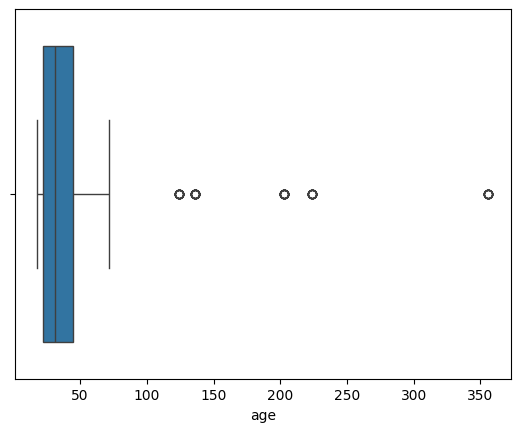

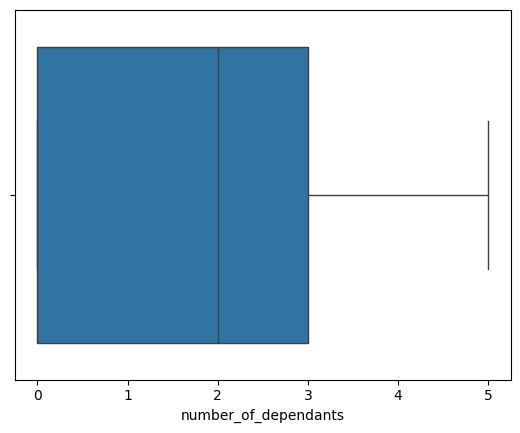

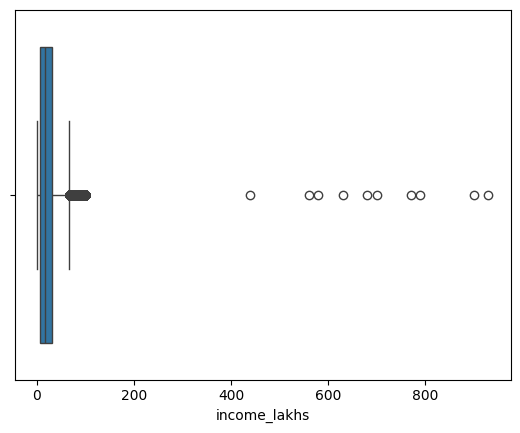

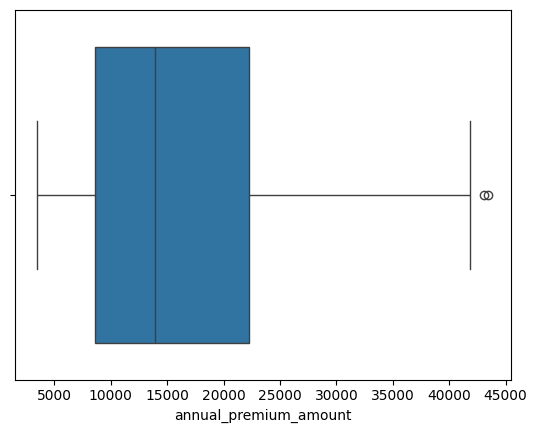

In [15]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [16]:
df[df.age > 100]["age"].unique()

array([224, 124, 136, 203, 356])

In [17]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

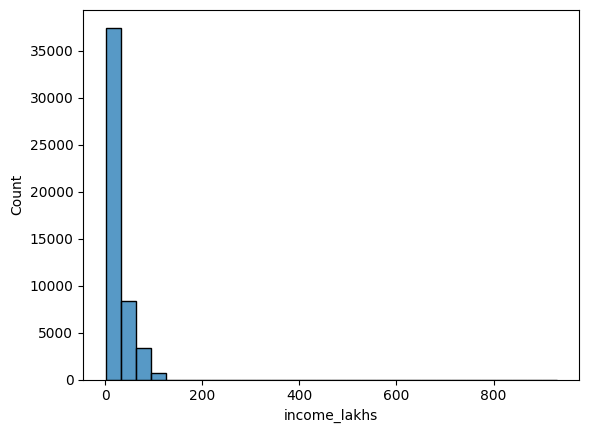

In [18]:
sns.histplot(df1.income_lakhs, bins=30)

In [19]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [20]:
def get_iqr_bounds(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [21]:
get_iqr_bounds(df1.income_lakhs)

(np.float64(-29.0), np.float64(67.0))

In [22]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [23]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


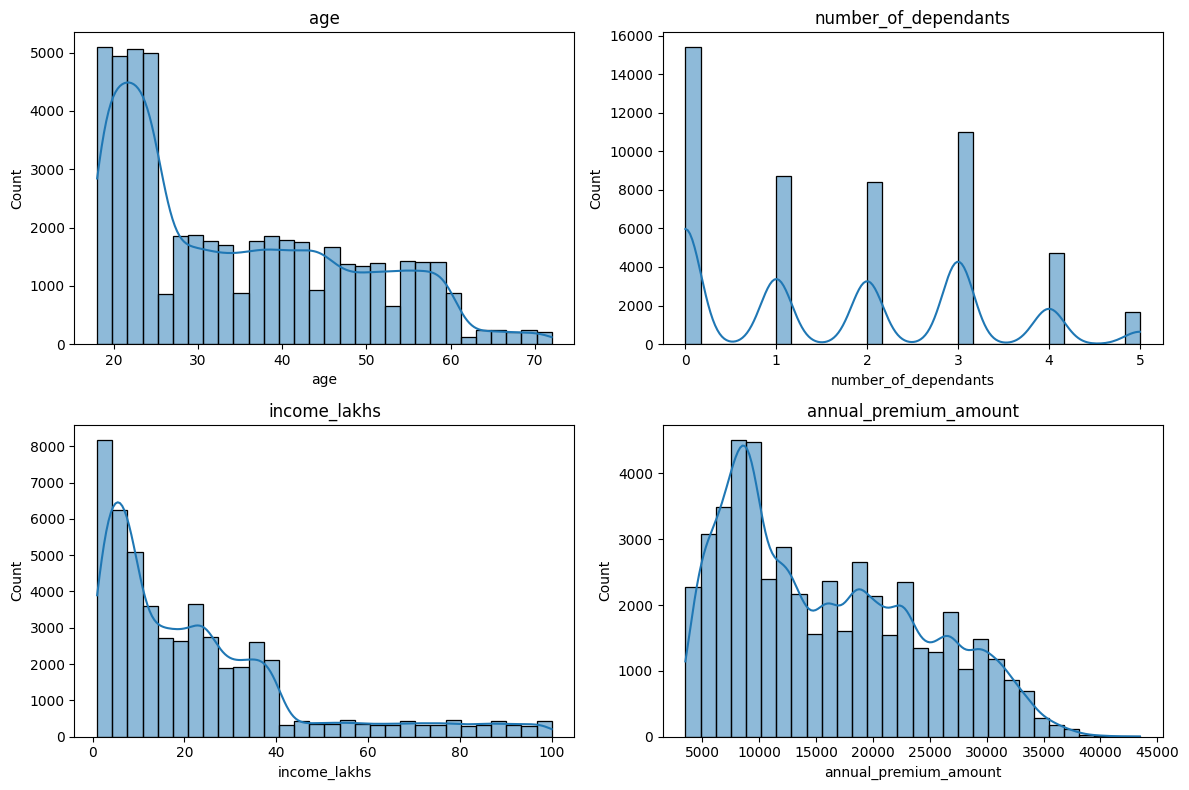

In [26]:
# Define the number of columns per row
num_cols = 2
num_plots = len(numeric_columns)
num_rows = (
    num_plots + num_cols - 1
) // num_cols  # To calculate the required number of rows

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(12, num_rows * 4)
)  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array

for i, col in enumerate(numeric_columns):
    sns.histplot(
        x=df2[col], kde=True, bins=30, ax=axes[i]
    )  # Plot in the respective subplot
    axes[i].set_title(col)

# Remove any empty subplots if num_plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

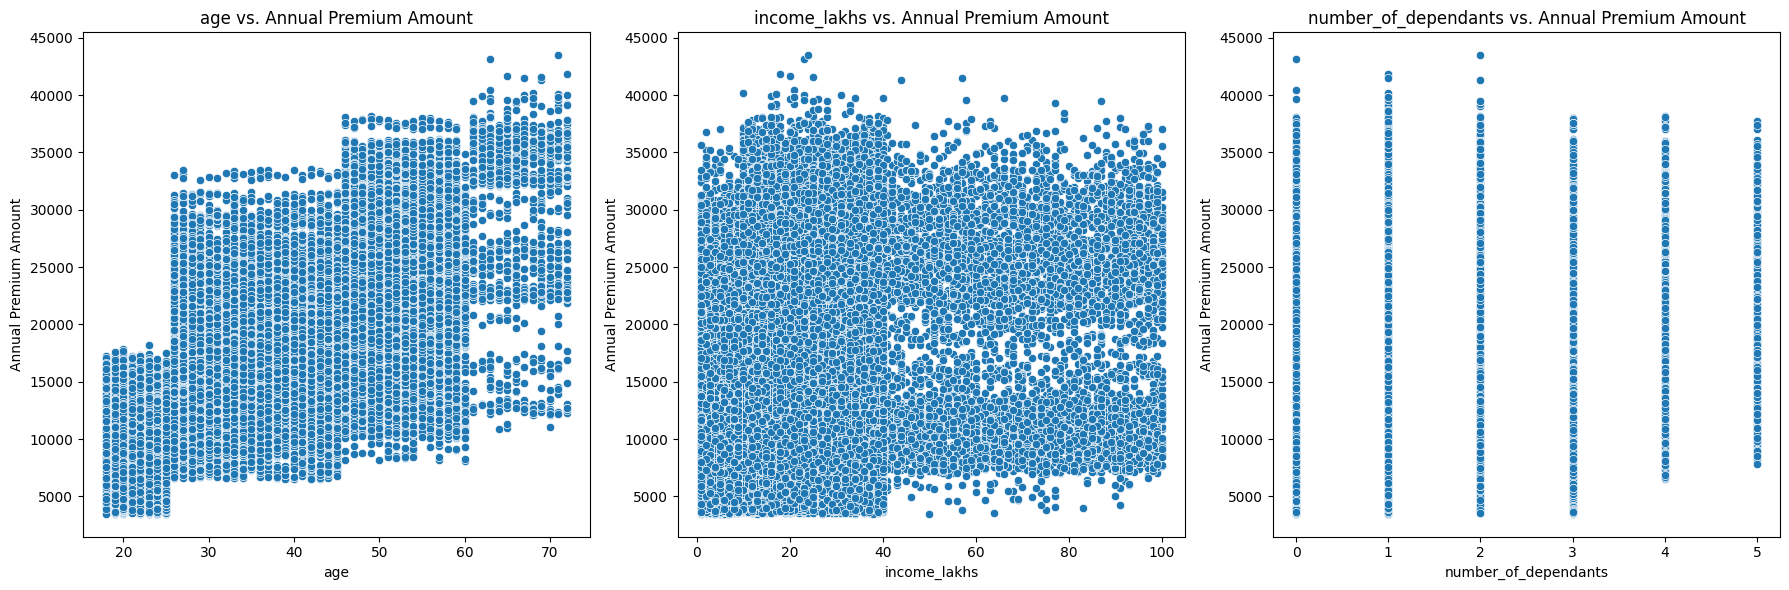

In [30]:
numeric_features = ["age", "income_lakhs", "number_of_dependants"]

fig, axes = plt.subplots(
    1, len(numeric_features), figsize=(18, 6)
)  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2["annual_premium_amount"], ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()  # Adjust layout
plt.show()

In [31]:
categorical_cols = [
    "gender",
    "region",
    "marital_status",
    "bmi_category",
    "smoking_status",
    "employment_status",
    "income_level",
    "medical_history",
    "insurance_plan",
]
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [32]:
df2["smoking_status"].replace(
    {
        "Not Smoking": "No Smoking",
        "Does Not Smoke": "No Smoking",
        "Smoking=0": "No Smoking",
    },
    inplace=True,
)

df2["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [34]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

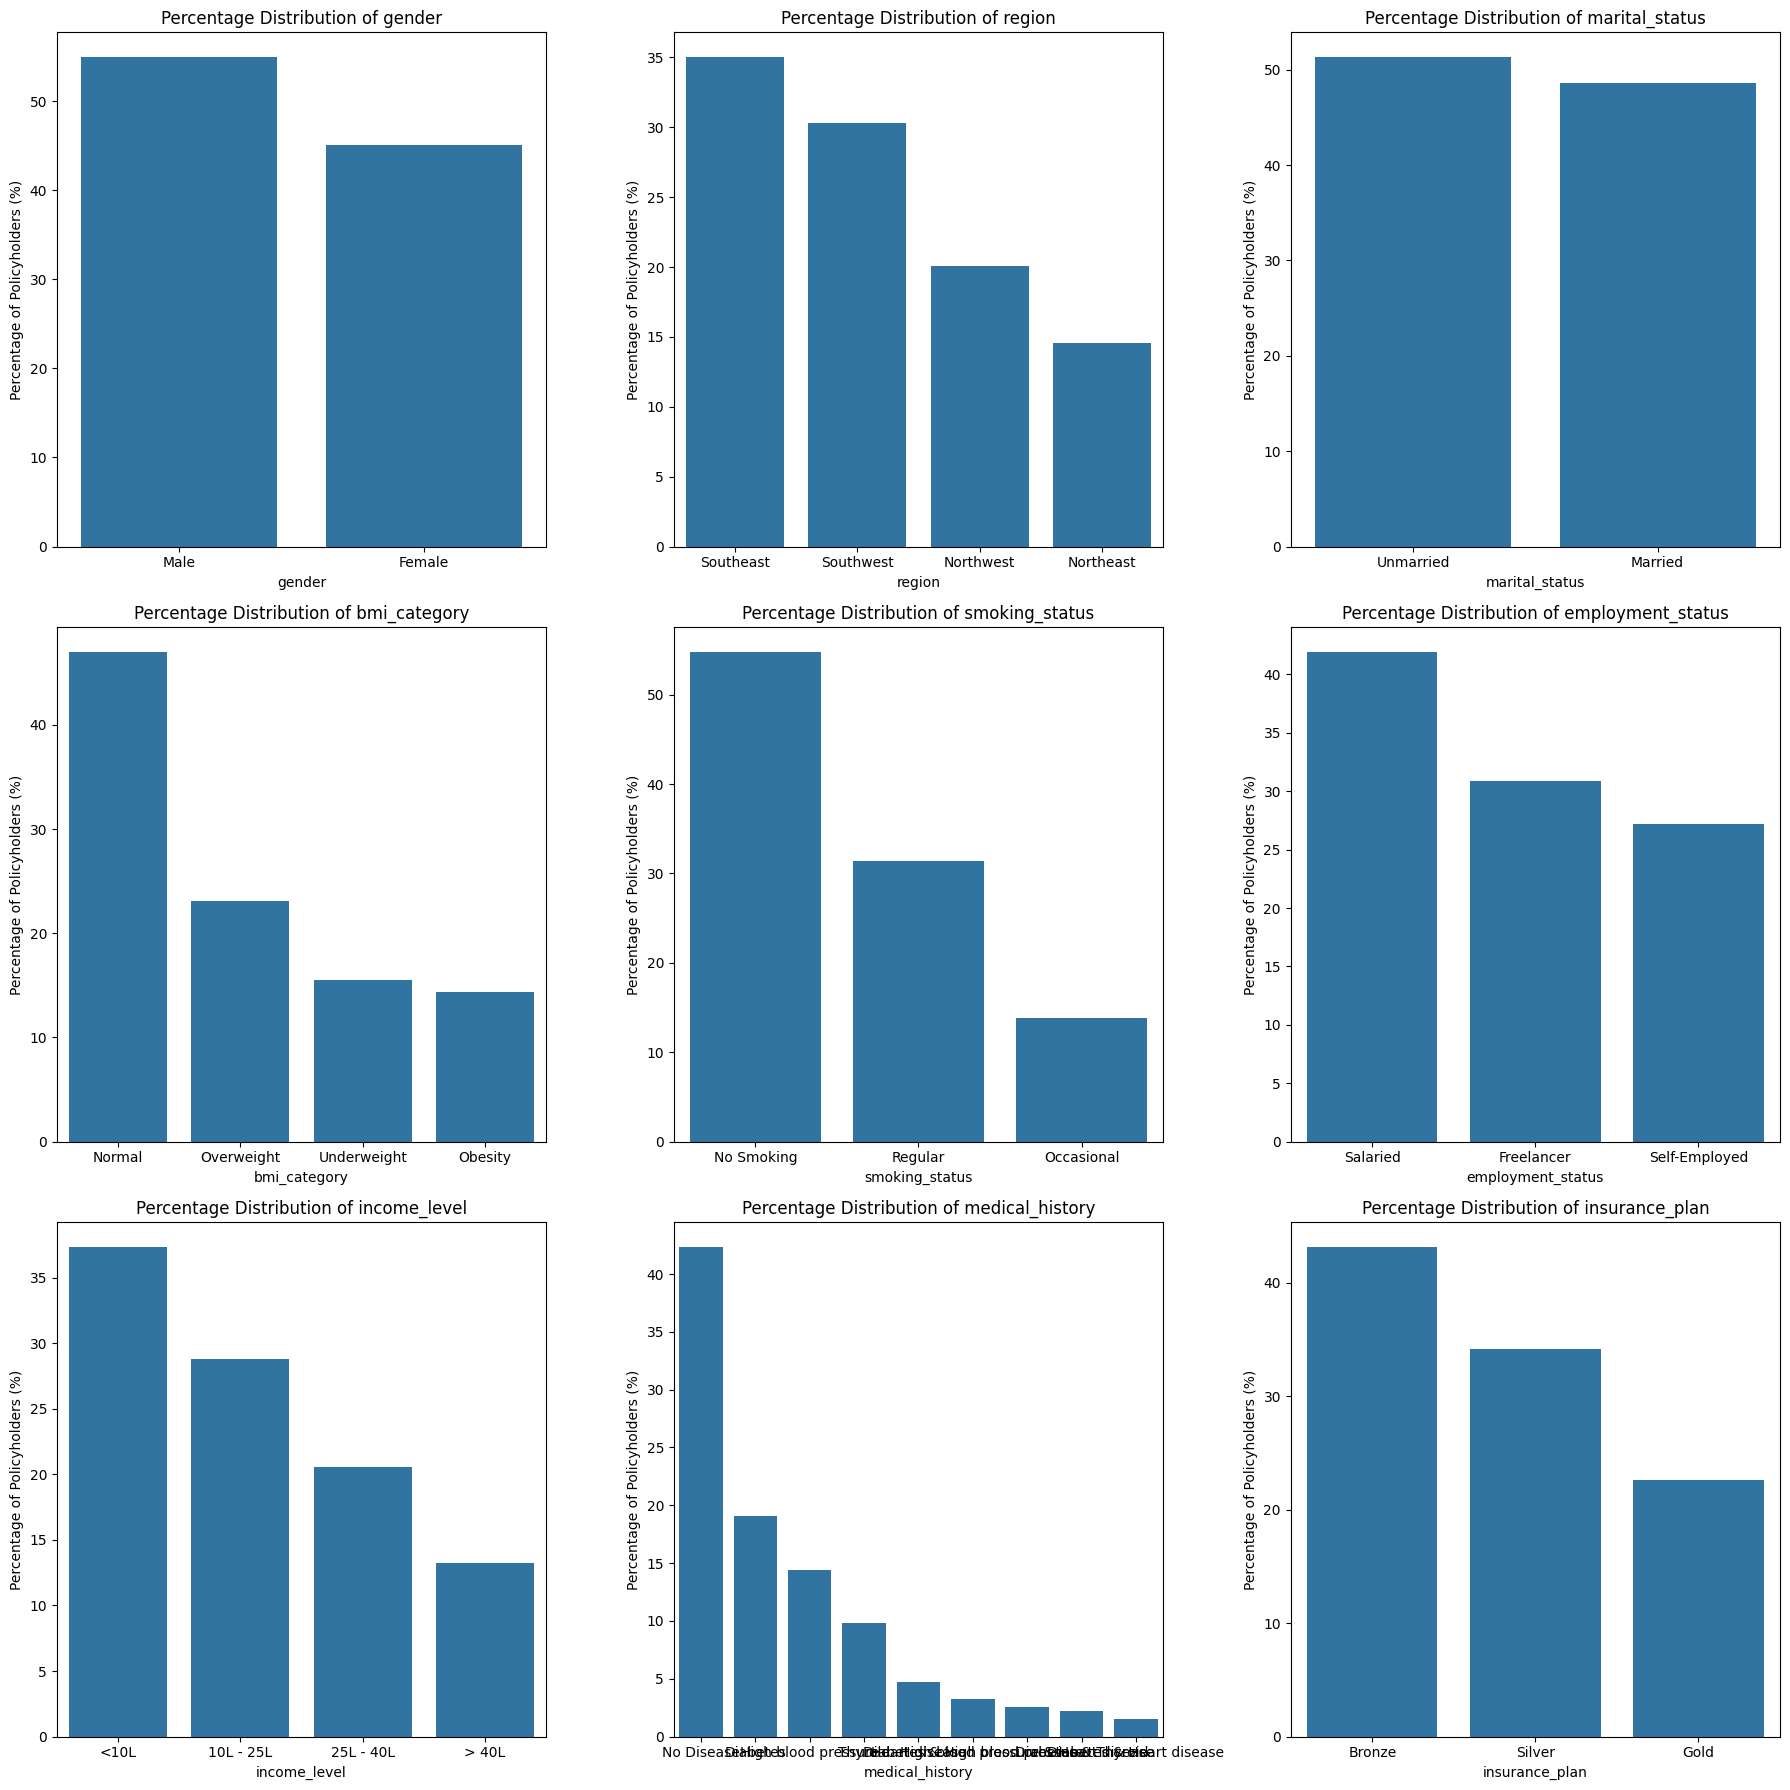

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = (
        df2[column].value_counts(normalize=True) * 100
    )  # normalize=True gives the relative frequencies

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage Distribution of {column}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


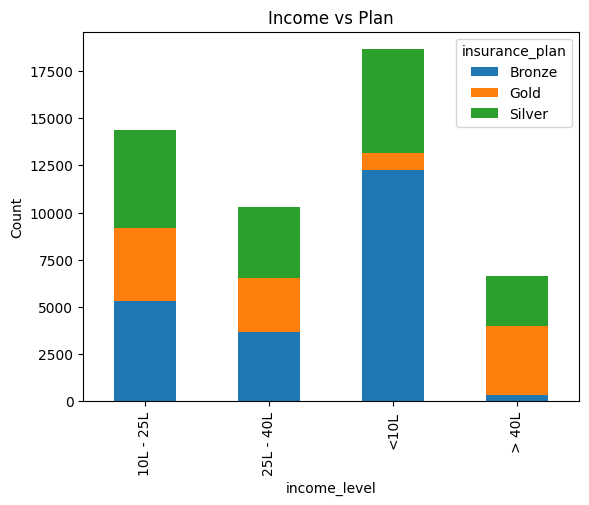

In [37]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2["income_level"], df2["insurance_plan"])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind="bar", stacked=True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

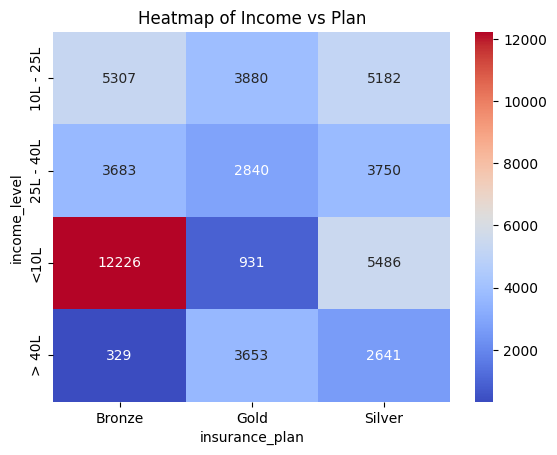

In [38]:
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Income vs Plan")
plt.show()

In [39]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [40]:
df2.medical_history.value_counts()

medical_history
No Disease                             21138
Diabetes                                9533
High blood pressure                     7209
Thyroid                                 4917
Heart disease                           2343
Diabetes & High blood pressure          1641
High blood pressure & Heart disease     1273
Diabetes & Thyroid                      1115
Diabetes & Heart disease                 739
Name: count, dtype: int64

In [41]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [42]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0,
}

df2[["disease1", "disease2"]] = (
    df2["medical_history"].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
)
df2["disease1"].fillna("none", inplace=True)
df2["disease2"].fillna("none", inplace=True)
df2["total_risk_score"] = 0

for disease in ["disease1", "disease2"]:
    df2["total_risk_score"] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2["total_risk_score"].max()
min_score = df2["total_risk_score"].min()
df2["normalized_risk_score"] = (df2["total_risk_score"] - min_score) / (
    max_score - min_score
)
df2.head(2)

C:\Users\sakif\AppData\Local\Temp\ipykernel_13084\238019341.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none", inplace=True)
C:\Users\sakif\AppData\Local\Temp\ipykernel_13084\238019341.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [45]:
df2["insurance_plan"] = df2["insurance_plan"].map({"Bronze": 1, "Silver": 2, "Gold": 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [46]:
df2["income_level"] = df2["income_level"].map(
    {"<10L": 1, "10L - 25L": 2, "25L - 40L": 3, "> 40L": 4}
)

In [48]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
17428,25,Female,Northeast,Unmarried,0,Normal,No Smoking,Freelancer,2,20,High blood pressure,1,5450,high blood pressure,none,6,0.428571
19601,25,Male,Northwest,Unmarried,1,Normal,Occasional,Self-Employed,2,18,No Disease,2,12329,no disease,none,0,0.000000
19086,50,Female,Northwest,Married,4,Obesity,Regular,Salaried,1,2,High blood pressure,2,25232,high blood pressure,none,6,0.428571
35199,30,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,2,25,Diabetes,2,15436,diabetes,none,6,0.428571
21908,25,Male,Northwest,Unmarried,0,Normal,No Smoking,Freelancer,1,6,No Disease,1,7504,no disease,none,0,0.000000
27497,26,Male,Northwest,Married,2,Overweight,No Smoking,Salaried,4,84,Thyroid,3,23898,thyroid,none,5,0.357143
12198,30,Female,Southeast,Married,4,Normal,Regular,Self-Employed,3,29,Diabetes,2,18360,diabetes,none,6,0.428571
27821,54,Female,Northwest,Married,4,Normal,Regular,Salaried,3,35,Diabetes,3,29427,diabetes,none,6,0.428571
43472,33,Male,Southwest,Married,4,Overweight,Regular,Freelancer,3,39,Diabetes,3,27510,diabetes,none,6,0.428571
30352,32,Male,Southeast,Married,3,Obesity,Regular,Salaried,2,14,Diabetes,3,29341,diabetes,none,6,0.428571


In [49]:
nominal_cols = [
    "gender",
    "region",
    "marital_status",
    "bmi_category",
    "smoking_status",
    "employment_status",
]
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [50]:
df4 = df3.drop(["medical_history", "disease1", "disease2", "total_risk_score"], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

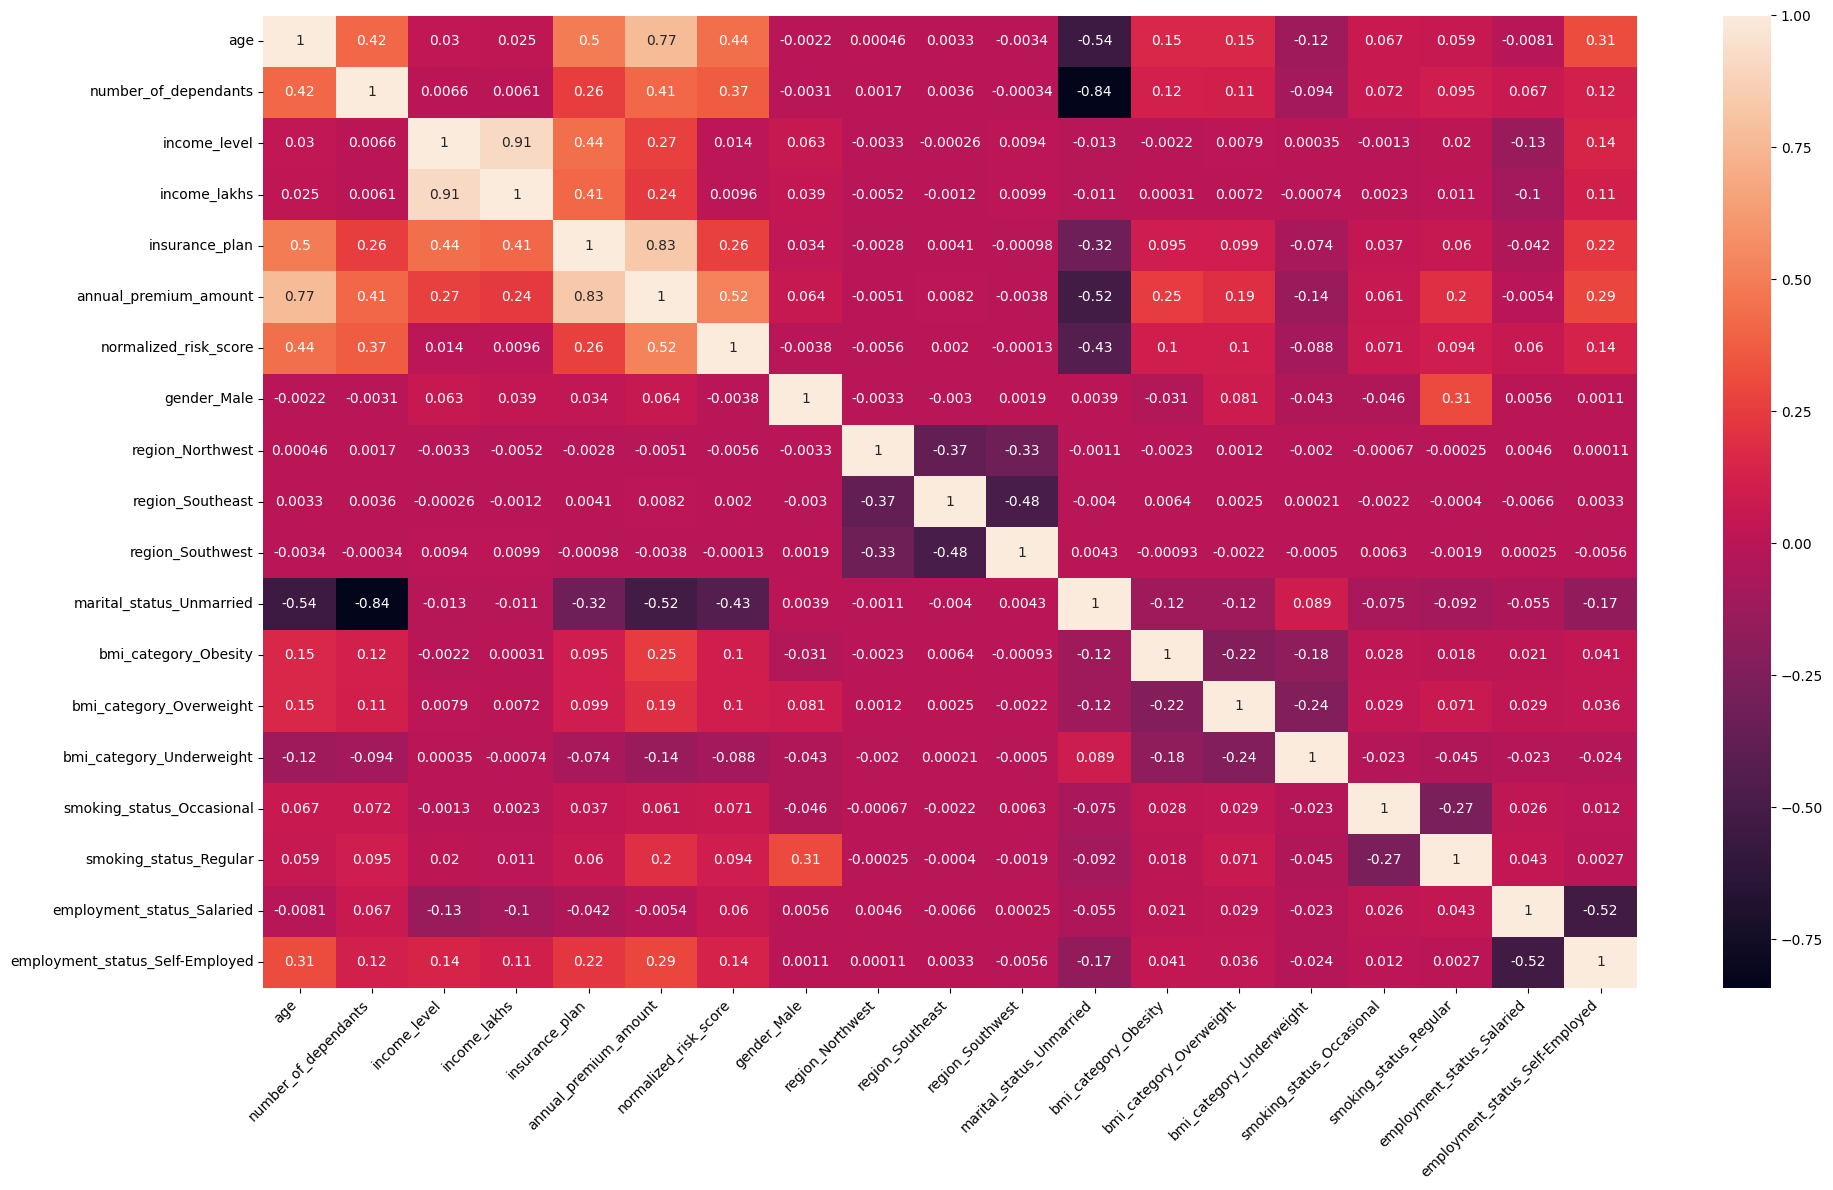

In [52]:
cm = df4.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
X = df4.drop("annual_premium_amount", axis="columns")
y = df4["annual_premium_amount"]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = [
    "age",
    "number_of_dependants",
    "income_level",
    "income_lakhs",
    "insurance_plan",
]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Column"] = data.columns
    vif_df["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_df

In [55]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [56]:
calculate_vif(X.drop("income_level", axis="columns"))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [58]:
# we will drop income_level due to high VIF value
X_reduced = X.drop("income_level", axis="columns")

### Model Training

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.30, random_state=10
)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


## LINEAR REGRESSION

In [60]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9282143576916762, 0.9280547230217837)

In [68]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  5165611.913027982 RMSE:  2272.798256121291


In [61]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [62]:
model_lr.intercept_

np.float64(4824.300272127104)

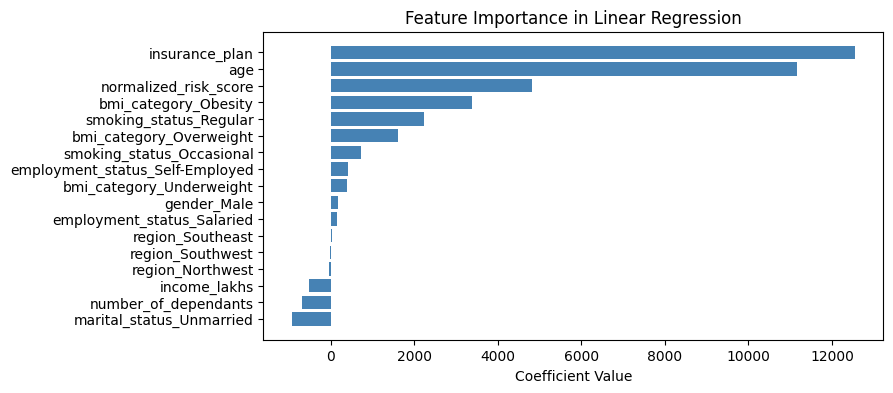

In [63]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(
    feature_importance, index=X_train.columns, columns=["Coefficients"]
)

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Linear Regression")
plt.show()

## RIDGE REGRESSION

In [64]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [65]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  5165652.017016523 RMSE:  2272.8070787060924


## XGBOOST

In [66]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9782300591468811

In [67]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1563064.1356043513 RMSE:  1250.2256338774819


In [69]:
model_xgb = XGBRegressor()
param_grid = {
    "n_estimators": [20, 40, 50],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}
random_search = RandomizedSearchCV(
    model_xgb, param_grid, n_iter=10, cv=3, scoring="r2", random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9809474547704061)

In [70]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [71]:
best_model = random_search.best_estimator_

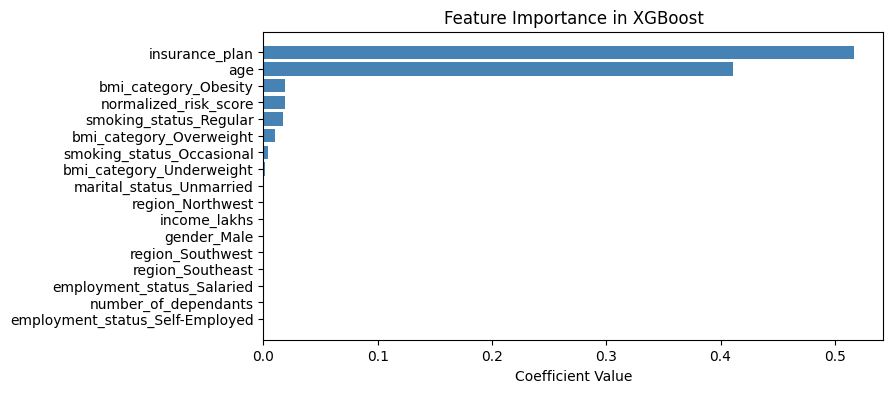

In [72]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(
    feature_importance, index=X_train.columns, columns=["Coefficients"]
)

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in XGBoost")
plt.show()